In [2]:
# !pip3 install rpy2

In [1]:
# R libraries
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

# Data wrangling
import pandas as pd
import numpy as np

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def read_rda(path, r_df_name):

    # Activate the automatic conversion of R objects to pandas objects
    pandas2ri.activate()

    # Path to your .rda file
    rda_file_path = path

    # Load the .rda file
    robjects.r['load'](rda_file_path)

    # Assuming the .rda file contains a single data frame named 'df_name'
    df_name = r_df_name

    # Retrieve the data frame from R environment
    r_dataframe = robjects.r[df_name]

    # Convert R data frame to pandas DataFrame
    try:
        pandas_dataframe = pandas2ri.rpy2py(r_dataframe)
    except TypeError as e:
        print("TypeError encountered:", e)
        # Attempt a manual conversion or inspect data structure
        pandas_dataframe = pd.DataFrame({key: list(val) for key, val in r_dataframe.items()})

    return pandas_dataframe

In [3]:
def harmonize_df(df, city_name, main_street_name):
    
    df.drop(columns = ['LONGITUDE', 'LATITUDE', 'geometry'], inplace = True)
    df['CITY'] = city_name
    main_street_dist = 'DISTANCE_TO_' + main_street_name
    df.rename(columns = {main_street_dist:'DISTANCE_TO_MAIN'}, inplace = True)

    return df

In [4]:
# Deduplicate
def dedupe(df):
    # Step 1: Sort by 'ASSETID', 'PERIOD' (descending), 'PRICE' (ascending)
    df_sorted = df.sort_values(by=['ASSETID', 'PERIOD', 'PRICE'], ascending=[True, False, False])

    # Step 2: Drop duplicates based on 'ASSETID', keeping the first occurrence
    df_ded = df_sorted.drop_duplicates(subset=['ASSETID'], keep='first')

    # Resulting DataFrame
    print('Original shape:', df.shape)
    print('Deduped shape:', df_ded.shape)

    return df_ded

## Read and process data

In [5]:
# Read and harmonize column names
df_mad = read_rda('../data-raw/Madrid_Sale.RData', 'Madrid_Sale')
df_mad = harmonize_df(df_mad, 'MADRID', 'CASTELLANA')

df_bcn = read_rda('../data-raw/Barcelona_Sale.RData', 'Barcelona_Sale')
df_bcn = harmonize_df(df_bcn, 'BARCELONA', 'DIAGONAL')

df_val = read_rda('../data-raw/Valencia_Sale.RData', 'Valencia_Sale')
df_val = harmonize_df(df_val, 'VALENCIA', 'BLASCO')

assert df_val.columns.all() == df_bcn.columns.all() == df_mad.columns.all()

TypeError encountered: 'NULLType' object is not iterable
TypeError encountered: 'NULLType' object is not iterable
TypeError encountered: 'NULLType' object is not iterable


In [6]:
# Deduplicate values
df_mad_ded = dedupe(df_mad)
df_bcn_ded = dedupe(df_bcn)
df_val_ded = dedupe(df_val)

Original shape: (94815, 40)
Deduped shape: (75804, 40)
Original shape: (61486, 40)
Deduped shape: (46729, 40)
Original shape: (33622, 40)
Deduped shape: (27391, 40)


In [7]:
# Merge all cities data
df = pd.concat([df_val, df_bcn, df_mad], axis = 0)

# Merge deduped data
df_ded = pd.concat([df_val_ded, df_bcn_ded, df_mad_ded], axis = 0)


In [8]:
# Save data
df_mad.to_csv('../data-csv/data_madrid.csv', index = False)
df_bcn.to_csv('../data-csv/data_barcelona.csv', index = False)
df_val.to_csv('../data-csv/data_valencia.csv', index = False)
df.to_csv('../data-csv/data_all.csv', index = False)

df_mad_ded.to_csv('../data-csv/data_madrid_ded.csv', index = False)
df_bcn_ded.to_csv('../data-csv/data_barcelona_ded.csv', index = False)
df_val_ded.to_csv('../data-csv/data_valencia_ded.csv', index = False)
df_ded.to_csv('../data-csv/data_all_ded.csv', index = False)

## Visualise

Text(0.5, 1.0, 'Madrid')

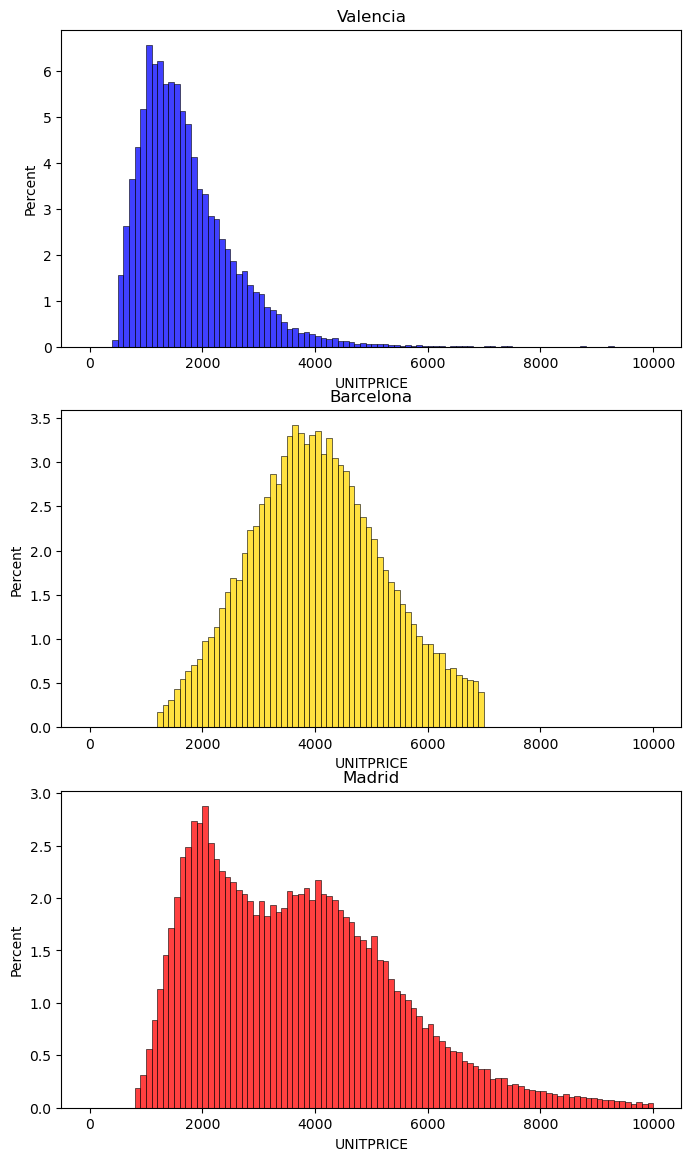

In [81]:
# Histograms

fig, ax = plt.subplots(3, 1, figsize = (8,14))

sns.histplot(df_val['UNITPRICE'], ax=ax[0], color = 'blue', stat = 'percent', binrange = (0,10000), binwidth=100)
ax[0].set_title('Valencia')
sns.histplot(df_bcn['UNITPRICE'], ax=ax[1], color = 'gold', stat = 'percent', binrange = (0,10000), binwidth=100)
ax[1].set_title('Barcelona')
sns.histplot(df_mad['UNITPRICE'], ax=ax[2], color = 'red', stat = 'percent', binrange = (0,10000), binwidth=100)
ax[2].set_title('Madrid')


<Axes: xlabel='ROOMNUMBER', ylabel='Count'>

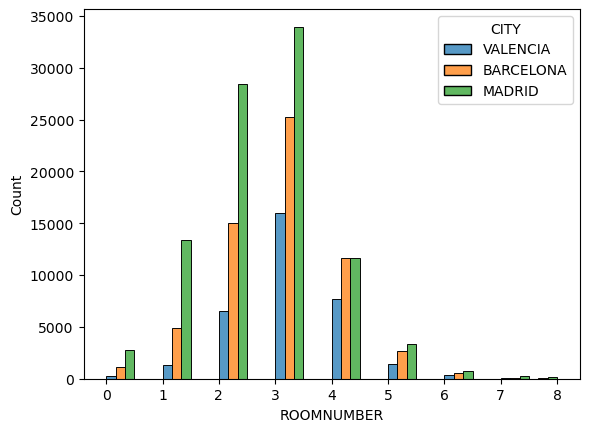

In [120]:
sns.histplot(data=df, x='ROOMNUMBER', hue='CITY', binrange=(0,8), binwidth=0.5, multiple = 'dodge')

<Axes: xlabel='CONSTRUCTEDAREA', ylabel='Density'>

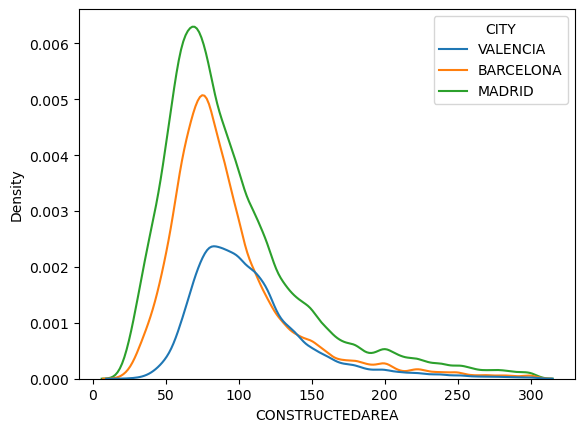

In [141]:
sns.kdeplot(data=df[df['CONSTRUCTEDAREA']<=300], x='CONSTRUCTEDAREA', hue='CITY')

<Axes: xlabel='CONSTRUCTIONYEAR', ylabel='Count'>

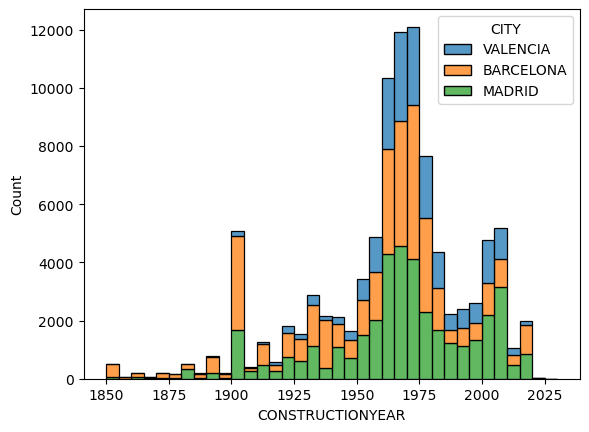

In [162]:
# sns.kdeplot(data=df[df['CONSTRUCTIONYEAR']>1800], x='CONSTRUCTIONYEAR', hue='CITY', cut = 0)
sns.histplot(data=df[df['CONSTRUCTIONYEAR']>1800], x='CONSTRUCTIONYEAR', hue='CITY', binrange=(1850, 2030),
             multiple='stack', binwidth=5)

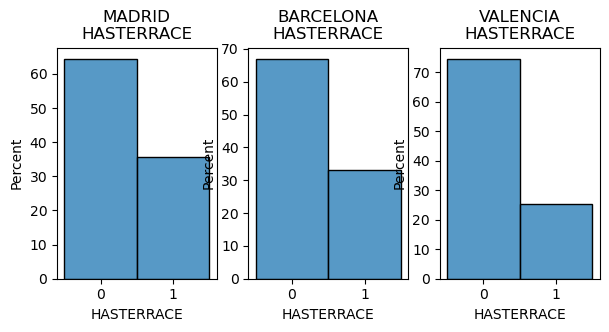

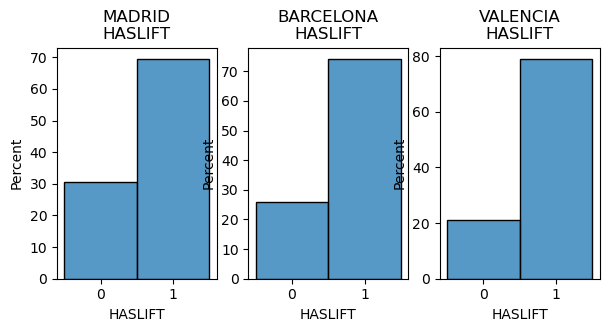

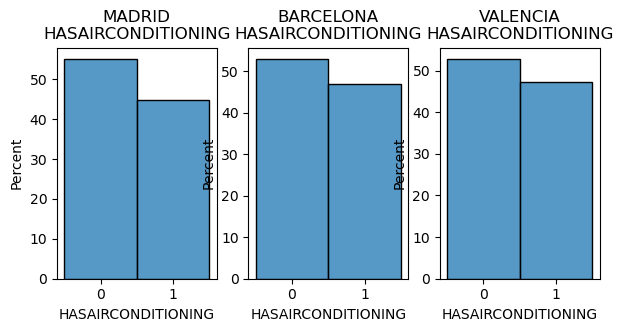

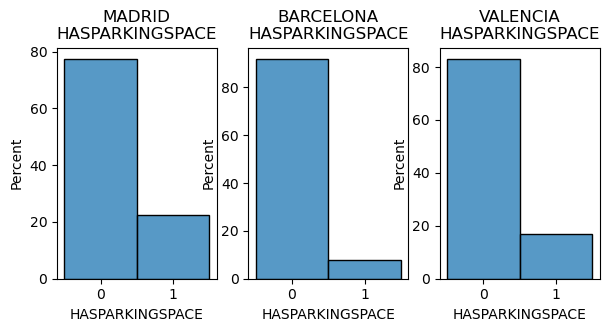

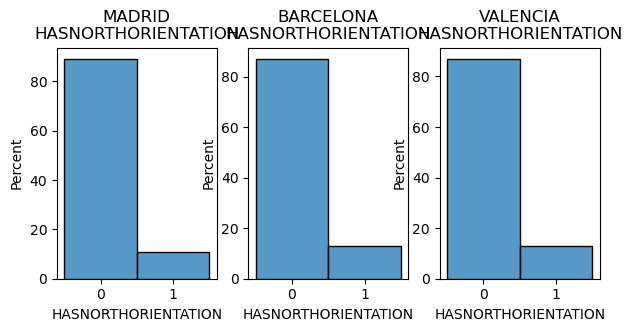

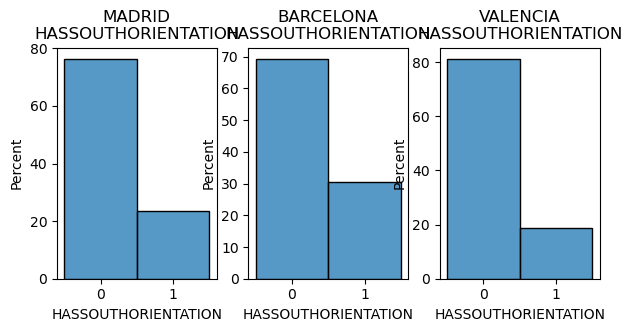

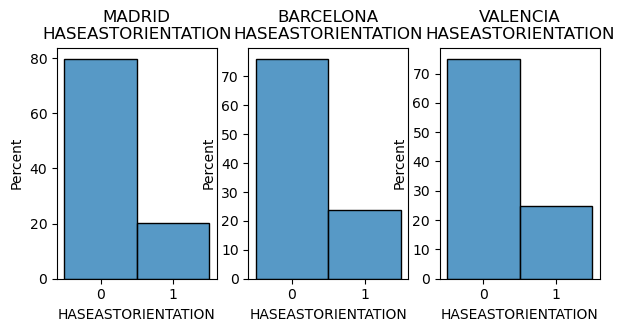

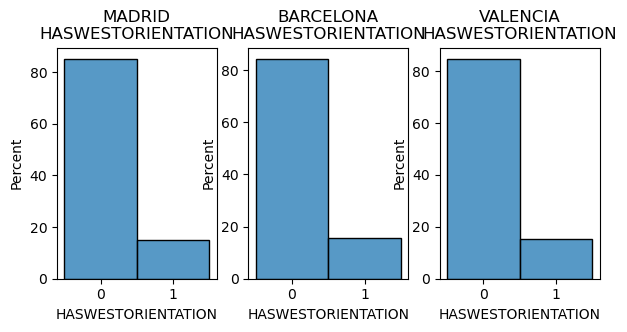

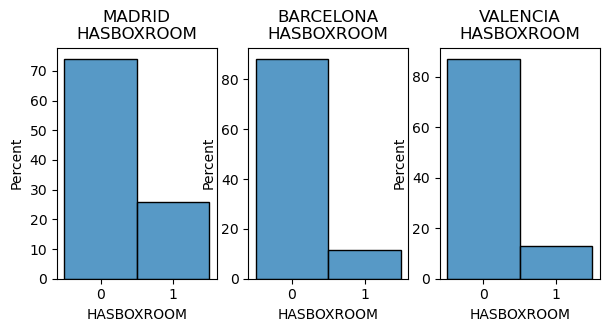

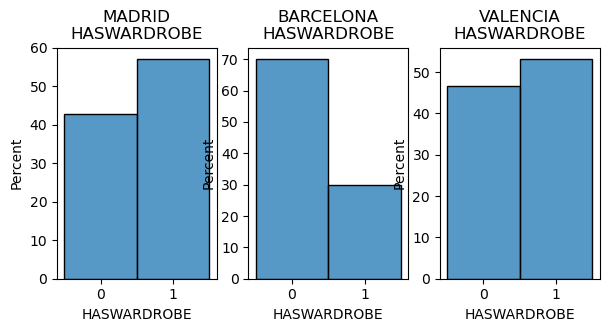

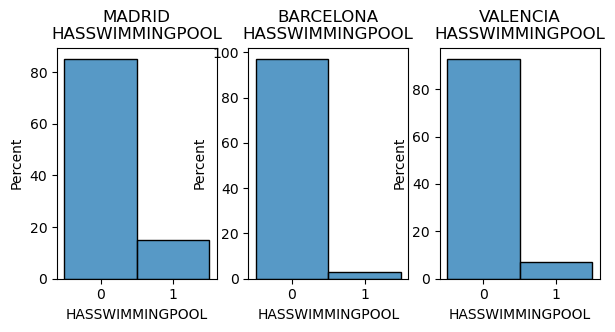

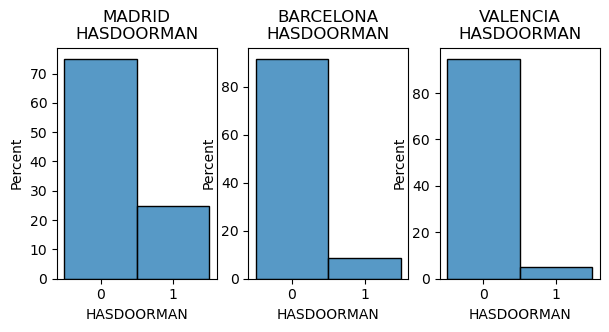

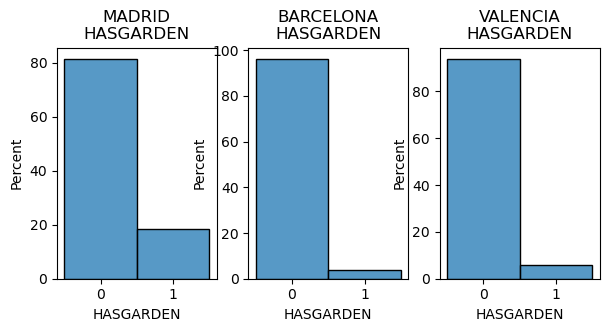

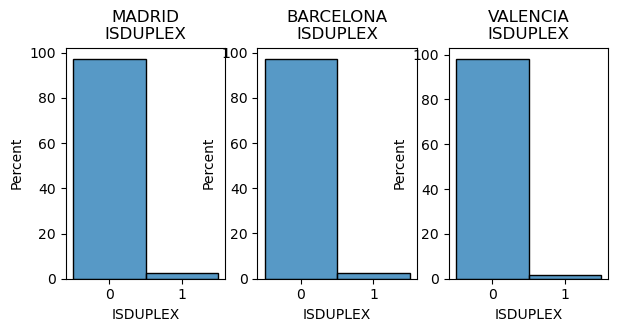

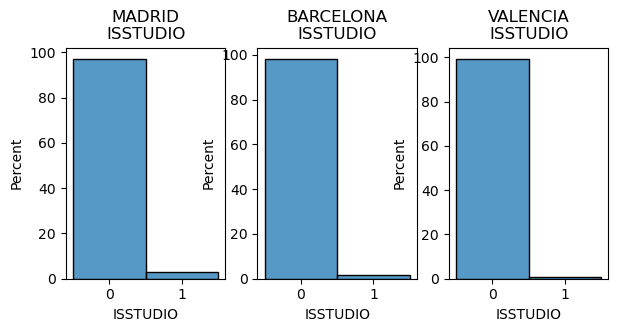

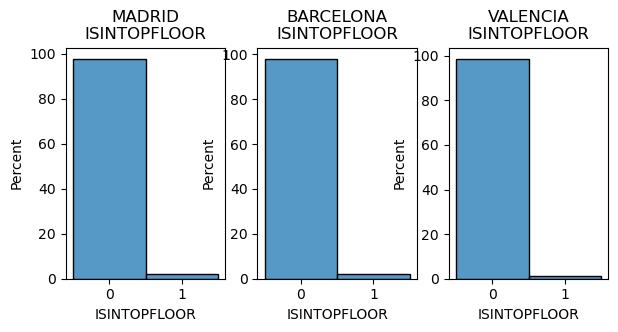

In [171]:
caracteristics = [
    'HASTERRACE', 'HASLIFT',
    'HASAIRCONDITIONING', 'HASPARKINGSPACE',
    'HASNORTHORIENTATION', 'HASSOUTHORIENTATION', 'HASEASTORIENTATION',
    'HASWESTORIENTATION', 'HASBOXROOM', 'HASWARDROBE', 'HASSWIMMINGPOOL',
    'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR'
]
cities = ['MADRID', 'BARCELONA', 'VALENCIA']

for car in caracteristics:
    fig, ax = plt.subplots(1, 3, figsize = (7,3))
    i = 0
    for city in cities:
        sns.histplot(data=df[df['CITY']==city], x=df[df['CITY']==city][car],
                multiple='dodge', discrete=1,
                stat='percent', ax = ax[i])
        ax[i].set_title(city + '\n' + car)
        i+=1
    plt.show()

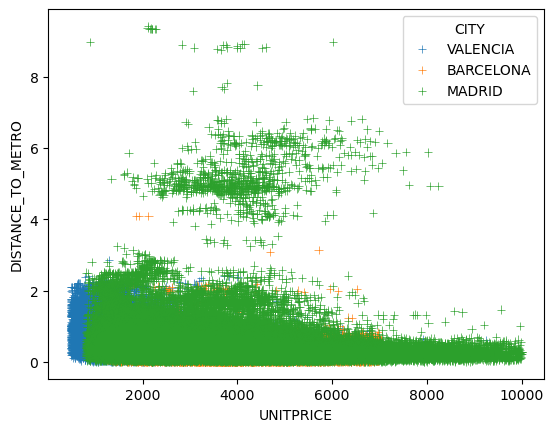

In [190]:
sns.scatterplot(data = df[df['DISTANCE_TO_METRO']<100], x = 'UNITPRICE', y = 'DISTANCE_TO_METRO', hue = 'CITY', marker='+')
plt.show()

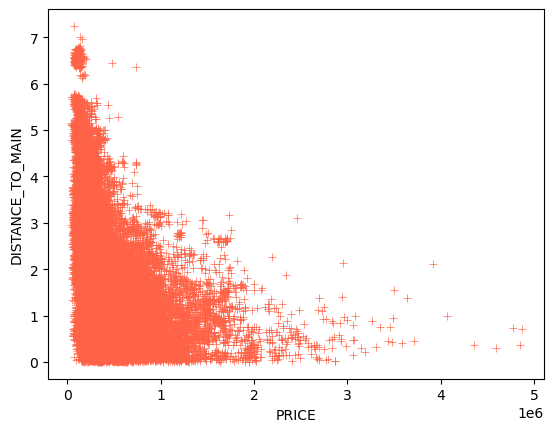

In [199]:
sns.scatterplot(data = df_bcn[df_bcn['DISTANCE_TO_MAIN']<100], x = 'PRICE', 
                y = 'DISTANCE_TO_MAIN', marker='+', color = 'tomato')
plt.show()

In [202]:
df_mad.columns

Index(['ASSETID', 'PERIOD', 'PRICE', 'UNITPRICE', 'CONSTRUCTEDAREA',
       'ROOMNUMBER', 'BATHNUMBER', 'HASTERRACE', 'HASLIFT',
       'HASAIRCONDITIONING', 'AMENITYID', 'HASPARKINGSPACE',
       'ISPARKINGSPACEINCLUDEDINPRICE', 'PARKINGSPACEPRICE',
       'HASNORTHORIENTATION', 'HASSOUTHORIENTATION', 'HASEASTORIENTATION',
       'HASWESTORIENTATION', 'HASBOXROOM', 'HASWARDROBE', 'HASSWIMMINGPOOL',
       'HASDOORMAN', 'HASGARDEN', 'ISDUPLEX', 'ISSTUDIO', 'ISINTOPFLOOR',
       'CONSTRUCTIONYEAR', 'FLOORCLEAN', 'FLATLOCATIONID',
       'CADCONSTRUCTIONYEAR', 'CADMAXBUILDINGFLOOR', 'CADDWELLINGCOUNT',
       'CADASTRALQUALITYID', 'BUILTTYPEID_1', 'BUILTTYPEID_2', 'BUILTTYPEID_3',
       'DISTANCE_TO_CITY_CENTER', 'DISTANCE_TO_METRO', 'DISTANCE_TO_MAIN',
       'CITY'],
      dtype='object')